# TIAFI Monthly reporting

[TIAFI's](https://tiafi.org/) monthly reporting notebook aims to help an NGO supporting Syrian refugees in Izmir, Turkey to gather insights on the organization's information point service (providing information and assistance to those who struggle with the Turkish language and/or following government guidance). For the sake of the organization's external reporting requirements, the data is analysed from the 21st to the 20th of each month.

## 1) Clean data

### 1.1 Read-in data

In [1]:
# imports libraries
import pandas as pd
import numpy as np 

# reads in the data
people = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/TIAFI-Data-Analysis/people_data.xlsx')
cases = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/TIAFI-Data-Analysis/cases_data.xlsx')
support = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/TIAFI-Data-Analysis/support_data.xlsx')

# reates a dataframes object for iteration. 
dataframes = ['people', 'cases','support']

# defines how many previous months to include
show_dates = 8

### 1.2 Create start/end dates

In [2]:
# creates a list of unique months in datetime format and converts them to string format 
datetimes = people.iloc[:,0].astype("datetime64[M]").unique() # datetime format (from the 1st day)
string_months = [str(date).split('T')[0] for date in datetimes] # string format (from the 1st day)
string_months = string_months[0:show_dates+1] # reduces the dates to the number specificied in show_dates

# creates two lists of unique months starting on the 20th and 21st
start = ['-'.join(month.split('-')[0:2]) + '-21' for month in string_months] # (from the 21st day)
end = ['-'.join(month.split('-')[0:2]) + '-20' for month in string_months] # (from the 20th day)

# creates two lists of matching start and end month pairs
start_months = start[1:len(start)]
end_months = end[0:(len(end)-1)]

### 1.3 Create simple date labels

In [3]:
# reverses the start/end months with most recent last
start_months.reverse()
end_months.reverse()

# creates simplified date labels for plotting
labels = []
for i in range(len(end_months)):
    labels.append(str(end_months[i]).split('-')[1] + '-' + str(end_months[i]).split('-')[0][2:4])
    
# re-assigns start/end dates so that they can be used for numerical filtering
start_months = [''.join(date.split('-')) for date in start_months]
end_months = [''.join(date.split('-')) for date in end_months]

### 1.4 Re-format dataframe dates

In [4]:
# transforms dataframe dates so that they can be numerically filtered. 
def transform_dates(df):
    temp_dates = df['date'].astype("datetime64[D]")
    df['date'] = [str(date).split(' ')[0] for date in temp_dates]

for i in range(len(dataframes)): 
    transform_dates(eval(dataframes[i]))

## 2) Data Analysis

### 2.1 Calculate totals

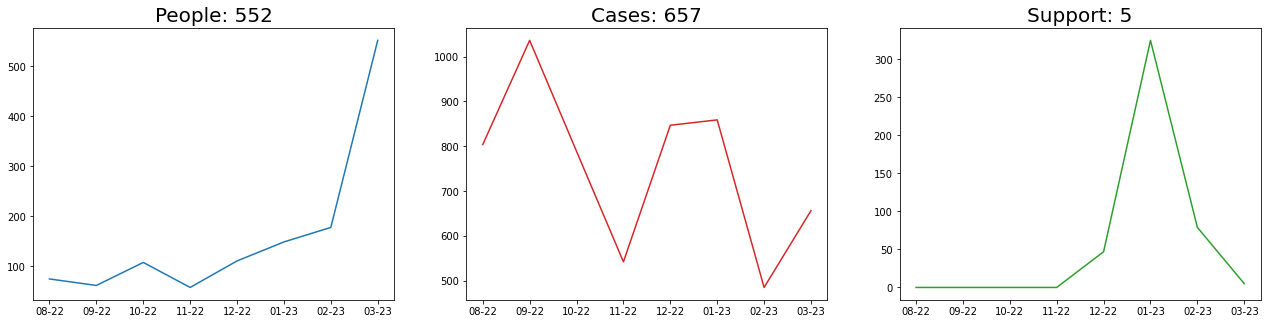

In [5]:
# plots the totals for people and cases
import matplotlib.pyplot as plt

# gets the totals for a given data frame
def get_totals(df):
    data = df
    totals = []
    for i in range(show_dates):
        data.reset_index(drop=True, inplace=True)
        data.date = [''.join(date.split('-')) for date in data.date]
        index = (len(start_months)-1)-i
        totals.append(sum([date >= start_months[index] and date <= end_months[index] for date in data.date]))
    totals.reverse()
    return totals

# creates a subplot
graph, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(22, 5))

# creates a people plot
plot1.plot(labels, get_totals(people), color='tab:blue')
plot1.set_title('People: ' + str(get_totals(people)[show_dates-1]), size=20); 

# creates a cases plot
plot2.plot(labels, get_totals(cases), color='tab:red')
plot2.set_title('Cases: ' + str(get_totals(cases)[show_dates-1]), size=20); 

# creates a support plot
plot3.plot(labels, get_totals(support), color='tab:green')
plot3.set_title('Support: ' + str(get_totals(support)[show_dates-1]), size=20); 

### 2.2 Unique cases

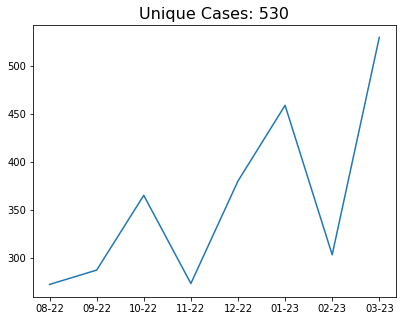

In [6]:
# plots the total for unique cases
def get_unique_cases(df):
    unique = []
    for i in range(len(start_months)):
        rows = [date > start_months[i] and date < end_months[i] for date in df.date]
        unique.append(len(df[rows].person_id.unique()))
    return unique

# creates a plot
graph, plot1 = plt.subplots(1, 1, figsize=(6.5, 5))

# creates a people plot
plot1.plot(labels[len(labels)-show_dates:len(labels)], get_unique_cases(cases)[len(labels)-show_dates:len(labels)], color='tab:blue')
plot1.set_title('Unique Cases: ' + str(get_unique_cases(cases)[len(start_months)-1]), size=16);

### 2.3 Solved cases

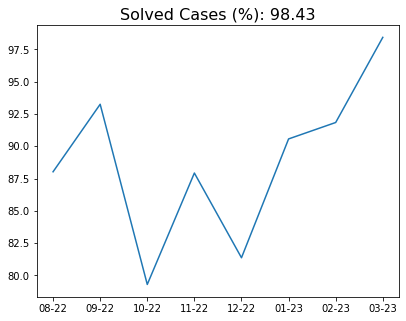

In [7]:
# plots the solved verses unsolved cases
def get_solved_cases(df):
    solved_percent = []
    for i in range(len(start_months)):
        rows = [date > start_months[i] and date < end_months[i] for date in df.date]
        solved = len([answer for answer in df[rows].solved if(answer in ['Yes', 'solved'])])
        solved_percent.append((solved / sum(rows))*100)
    return solved_percent

# creates a plot
graph, plot1 = plt.subplots(1, 1, figsize=(6.5, 5))

# creates a people plot
plot1.plot(labels[len(labels)-show_dates:len(labels)], get_solved_cases(cases)[len(labels)-show_dates:len(labels)],color='tab:blue')
plot1.set_title('Solved Cases (%): ' + str(round(get_solved_cases(cases)[len(start_months)-1],2)), size=16);

### 2.4 Top case reasons

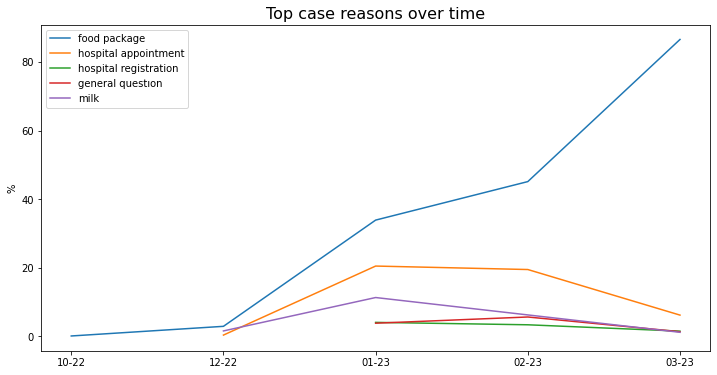

In [8]:
# sets how many reasons to show
show_reasons = 5

# creates a length for the number of dates
length = len(start_months)-1

# filters out a problematic case reason value
cases = cases.loc[cases.reason != 'Other']

# converts all strings to lower
cases.reason = cases.reason.str.lower()

case_reasons = []
for i in range(show_dates):
    # selects the neccesarry rows within the date range
    rows = [date > start_months[length-i] and date < end_months[length-i] for date in cases.date]
    
    # groups and the data by reason
    grouped_reasons = cases[rows].groupby('reason').sum().sort_values('quantity', ascending=False)
    reasons_table = grouped_reasons.drop('case_id', axis=1).iloc[range(0,len(grouped_reasons)),range(0,1)]
    
    # creates reason, quantity and percent columns for analysis
    reason = reasons_table.index
    quantity = reasons_table.iloc[range(0, len(reasons_table)),0]
    percent = round((quantity / grouped_reasons.quantity.sum())*100, 2)
    
    # creates a series of data frames to better view the data
    d = {'Reason':reason, 'Quantity':quantity, 
         'Percent':percent, 'Month': str(labels[length-i])}
    new_df = pd.DataFrame(d)
    new_df.reset_index(drop=True, inplace=True)
    case_reasons.append(new_df)
    
# plots the top case reasons
new_df = pd.concat(case_reasons).reset_index(drop=True)
top = list(new_df.Reason.iloc[range(0,show_reasons)])
reasons = list(new_df.Reason)
rows = [reason in top for reason in reasons]
final_df = new_df[rows].reset_index(drop=True)

unique = final_df.Reason.unique()

# creates a reasons percent change plot 
graph, plot1 = plt.subplots(1, 1, figsize=(12, 6))

for i in range(len(unique)):
    data = final_df[final_df.Reason==unique[i]]
    plot1.plot(data.Month, data.Percent, label=data.Reason[i]);
    
plot1.invert_xaxis();
plot1.set_title('Top case reasons over time', size=16)
plot1.set_ylabel('%')
plot1.legend();

### 2.5 Biggest case reason increases

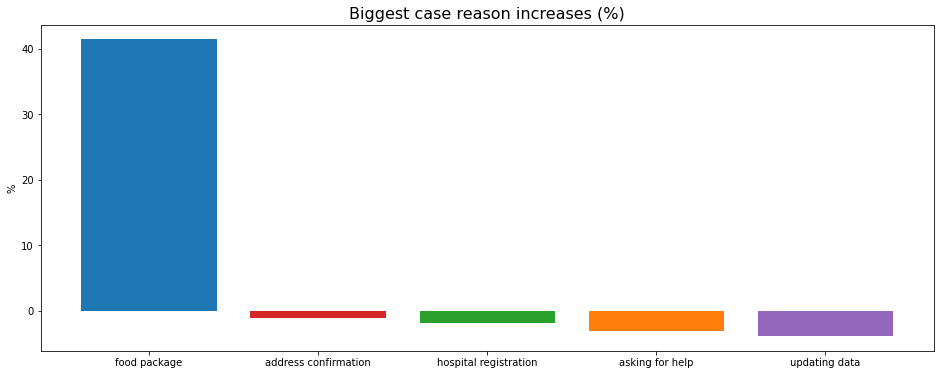

In [9]:
# creates a filter data frame with only the previous two months
recent_months = new_df.Month.unique()[range(0,2)]
comparison_index = [month in list(recent_months) for month in new_df.Month]
comparison_df = new_df[comparison_index]

# filters the data frame for only reasons with at least two values 
quantity = comparison_df.groupby('Reason').count()
two_values = quantity[quantity.Quantity > 1].index
index = [reason in list(two_values) for reason in comparison_df.Reason]
comparison_df = comparison_df[index]

# creates a data frame of the percentage difference on the previous month
difference = []
for i in range(len(two_values)):
    reason = two_values[i]
    data = comparison_df[comparison_df.Reason==reason]
    data.reset_index(drop=True, inplace=True)
    current = data.iloc[0].Percent
    last = data.iloc[1].Percent
    difference.append(round(current-last,2))
    
d = {'Reason': two_values,'Difference': difference}
comparison_df = pd.DataFrame(d)

colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:yellow', 'tab:cyan', 'tab:black', 'tab:brown']

# creates biggest percent decrease plot 
biggest_increase = comparison_df.sort_values('Difference', ascending=False).iloc[range(0,show_reasons)]
graph, plot1 = plt.subplots(1, 1, figsize=(16, 6))
plot1.bar(biggest_increase.Reason, height=biggest_increase.Difference, color=colors[0:show_reasons]);
plot1.set_title('Biggest case reason increases (%)', size=16);
plot1.set_ylabel('%');

### 2.5 Biggest case reason decreases

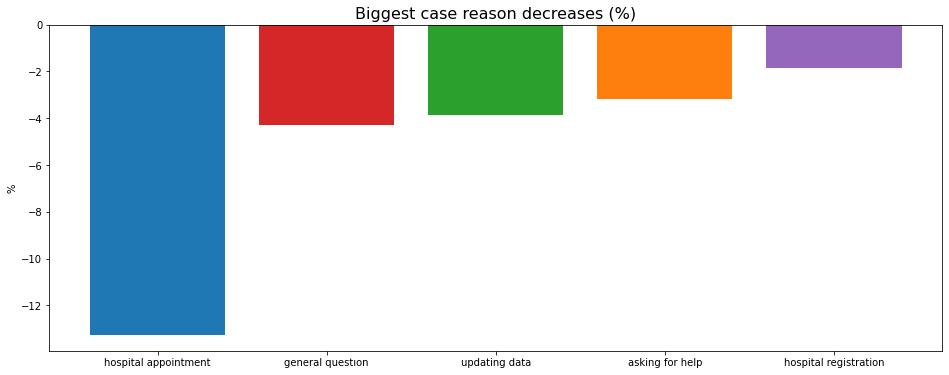

In [10]:
# creates biggest percent decrease plot 
biggest_decrease = comparison_df.sort_values('Difference').iloc[range(0,show_reasons)]
graph, plot1 = plt.subplots(1, 1, figsize=(16, 6))
plot1.bar(biggest_decrease.Reason, height=biggest_decrease.Difference, color=colors[0:show_reasons]);
plot1.set_title('Biggest case reason decreases (%)', size=16);
plot1.set_ylabel('%');